## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])

    return model

In [6]:
LEARNING_RATE = 0.1
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1, 0.01]
redice_lr_patient = [2, 5, 10]

In [8]:
from keras import backend as K
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    K.set_value(model.optimizer.lr, LEARNING_RATE) # reset the learning rate at every start
    #print("Numbers of exp: %i, lr: %f, reduce_factor: %.2f, reduce_patient: %i" % (i, K.get_value(model.optimizer.lr), reduce_factor, reduce_patient))

    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss',
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25


Epoch 15/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4185 - accuracy: 0.4905 - val_loss: 1.4855 - val_accuracy: 0.4773
Epoch 16/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3944 - accuracy: 0.5014 - val_loss: 1.4609 - val_accuracy: 0.4811
Epoch 17/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3581 - accuracy: 0.5119 - val_loss: 1.4524 - val_accuracy: 0.4905
Epoch 18/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.3722 - accuracy: 0.5059 - val_loss: 1.4395 - val_accuracy: 0.4945
Epoch 19/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.3431 - accuracy: 0.5180 - val_loss: 1.4567 - val_accuracy: 0.4822
Epoch 20/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.3177 - accuracy: 0.5283 - val_loss: 1.4503 - val_accuracy: 0.4882
Epoch 21/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3276 - accuracy: 0.5234

50000/50000 [==============================] - 7s 138us/step - loss: 1.8317 - accuracy: 0.3325 - val_loss: 1.8325 - val_accuracy: 0.3318
Epoch 5/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.7912 - accuracy: 0.3551 - val_loss: 1.7445 - val_accuracy: 0.3655
Epoch 6/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.7317 - accuracy: 0.3790 - val_loss: 1.6697 - val_accuracy: 0.3990
Epoch 7/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6863 - accuracy: 0.3988 - val_loss: 1.6389 - val_accuracy: 0.4165
Epoch 8/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.6553 - accuracy: 0.4099 - val_loss: 1.6736 - val_accuracy: 0.4043
Epoch 9/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.6222 - accuracy: 0.4224 - val_loss: 1.6633 - val_accuracy: 0.4056

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 10/25
50000/50000 [==================

50000/50000 [==============================] - 7s 140us/step - loss: 1.1183 - accuracy: 0.5970 - val_loss: 1.4382 - val_accuracy: 0.5031
Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 10
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable

50000/50000 [==============================] - 7s 144us/step - loss: 1.7948 - accuracy: 0.3798 - val_loss: 1.7436 - val_accuracy: 0.3827
Epoch 15/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5882 - accuracy: 0.4379 - val_loss: 1.6180 - val_accuracy: 0.4249

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 16/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.5169 - accuracy: 0.4640 - val_loss: 1.5979 - val_accuracy: 0.4319
Epoch 17/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5084 - accuracy: 0.4668 - val_loss: 1.5954 - val_accuracy: 0.4340

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-07.
Epoch 18/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.5068 - accuracy: 0.4676 - val_loss: 1.5949 - val_accuracy: 0.4349
Epoch 19/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.5066 - accuracy: 0.4

50000/50000 [==============================] - 7s 137us/step - loss: 2.2452 - accuracy: 0.1777 - val_loss: 2.0438 - val_accuracy: 0.2384
Epoch 2/25
50000/50000 [==============================] - 7s 136us/step - loss: 2.2129 - accuracy: 0.1707 - val_loss: 2.1563 - val_accuracy: 0.1643
Epoch 3/25
50000/50000 [==============================] - 7s 136us/step - loss: 2.1215 - accuracy: 0.1747 - val_loss: 2.0731 - val_accuracy: 0.2036
Epoch 4/25
50000/50000 [==============================] - 7s 135us/step - loss: 2.0079 - accuracy: 0.2436 - val_loss: 1.9538 - val_accuracy: 0.2752
Epoch 5/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.9291 - accuracy: 0.2880 - val_loss: 1.9289 - val_accuracy: 0.2873
Epoch 6/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.8596 - accuracy: 0.3190 - val_loss: 1.8323 - val_accuracy: 0.3274
Epoch 7/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.8078 - accuracy: 0.3418 - val_loss: 1.785

Epoch 20/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.0990 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0003906250058207661.
Epoch 21/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 22/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00019531250291038305.
Epoch 23/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 24/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.765625145519152e-05.
Epoch 25/25

Epoch 7/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3051 - accuracy: 0.0981 - val_loss: 2.3059 - val_accuracy: 0.1000
Epoch 8/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3062 - accuracy: 0.1012 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 9/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3069 - accuracy: 0.1013 - val_loss: 2.3159 - val_accuracy: 0.1000
Epoch 10/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3074 - accuracy: 0.0999 - val_loss: 2.3112 - val_accuracy: 0.1000
Epoch 11/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.3068 - accuracy: 0.1002 - val_loss: 2.3080 - val_accuracy: 0.1000
Epoch 12/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3063 - accuracy: 0.1002 - val_loss: 2.3070 - val_accuracy: 0.1000
Epoch 13/25
50000/50000 [==============================] - 7s 138us/step - loss: 2.3051 - accuracy: 0.0996 - 

50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 3.8355 - val_accuracy: 0.1000

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 24/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 3.8355 - val_accuracy: 0.1000
Epoch 25/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 3.8355 - val_accuracy: 0.1000
Numbers of exp: 13, reduce_factor: 0.10, reduce_patient: 5
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)      

Epoch 11/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.3031 - accuracy: 0.0985 - val_loss: 282.1556 - val_accuracy: 0.1000
Epoch 12/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.3033 - accuracy: 0.0997 - val_loss: 282.1554 - val_accuracy: 0.1000
Epoch 13/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.3033 - accuracy: 0.0990 - val_loss: 282.1554 - val_accuracy: 0.1000
Epoch 14/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.3032 - accuracy: 0.0991 - val_loss: 282.1556 - val_accuracy: 0.1000

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 15/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.3029 - accuracy: 0.0992 - val_loss: 282.1551 - val_accuracy: 0.1000
Epoch 16/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.3027 - accuracy: 0.0954 - val_loss: 282.1550 - val_accuracy: 0.1000
Epoch 17/25
50

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 148us/step - loss: 47754.8077 - accuracy: 0.0984 - val_loss: 2.5665 - val_accuracy: 0.1000
Epoch 2/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.3581 - accuracy: 0.0995 - val_loss: 2.3046 - val_accuracy: 0.1000
Epoch 3/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.3036 - accuracy: 0.0996 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 4/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3032 - accuracy: 0.1011 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 5/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3032 - accuracy: 0.1007 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 6/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3032 - accuracy: 0.0993 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 7/25
50000/50000 [==============================] - 

Epoch 21/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 651.3223 - val_accuracy: 0.1000
Epoch 22/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 651.3223 - val_accuracy: 0.1000

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 23/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 651.3223 - val_accuracy: 0.1000
Epoch 24/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 651.3223 - val_accuracy: 0.1000
Epoch 25/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 651.3223 - val_accuracy: 0.1000
Numbers of exp: 18, reduce_factor: 0.50, reduce_patient: 2
Model: "model_19"
_________________________________________________________________
Layer (type)        

50000/50000 [==============================] - 7s 138us/step - loss: 2.3056 - accuracy: 0.1006 - val_loss: 2.3066 - val_accuracy: 0.1000
Epoch 7/25
50000/50000 [==============================] - 7s 138us/step - loss: 2.3058 - accuracy: 0.1000 - val_loss: 2.3050 - val_accuracy: 0.1000
Epoch 8/25
50000/50000 [==============================] - 7s 138us/step - loss: 2.3051 - accuracy: 0.1019 - val_loss: 2.3052 - val_accuracy: 0.1000
Epoch 9/25
50000/50000 [==============================] - 7s 137us/step - loss: 2.3060 - accuracy: 0.0993 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 10/25
50000/50000 [==============================] - 7s 141us/step - loss: 2.3057 - accuracy: 0.1008 - val_loss: 2.3060 - val_accuracy: 0.1000
Epoch 11/25
50000/50000 [==============================] - 7s 138us/step - loss: 2.3051 - accuracy: 0.1017 - val_loss: 2.3043 - val_accuracy: 0.1000
Epoch 12/25
50000/50000 [==============================] - 7s 138us/step - loss: 2.3058 - accuracy: 0.0999 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 149us/step - loss: 43096.2318 - accuracy: 0.1032 - val_loss: 2.3105 - val_accuracy: 0.1013
Epoch 2/25
50000/50000 [==============================] - 7s 144us/step - loss: 239.7168 - accuracy: 0.0975 - val_loss: 3.1057 - val_accuracy: 0.1003
Epoch 3/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.4257 - accuracy: 0.0978 - val_loss: 2.3463 - val_accuracy: 0.1000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 4/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3036 - accuracy: 0.0970 - val_loss: 2.3349 - val_accuracy: 0.0999
Epoch 5/25
50000/50000 [==============================] - 7s 144us/step - loss: 2.3032 - accuracy: 0.0975 - val_loss: 2.3345 - val_accuracy: 0.0999

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/25
50000/50000 [===================


Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 17/25
50000/50000 [==============================] - 7s 141us/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 18/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.3027 - accuracy: 0.0994 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 19/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3026 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 20/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3026 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 21/25
50000/50000 [==============================] - 7s 141us/step - loss: 2.3026 - accuracy: 0.0971 - val_loss: 2.3026 - val_accuracy: 0.1000

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 22/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.3026 - acc

50000/50000 [==============================] - 8s 154us/step - loss: 2.3140 - accuracy: 0.1001 - val_loss: 2.3079 - val_accuracy: 0.1001
Epoch 6/25
50000/50000 [==============================] - 7s 148us/step - loss: 2.3072 - accuracy: 0.1002 - val_loss: 2.3056 - val_accuracy: 0.1004
Epoch 7/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3049 - accuracy: 0.1004 - val_loss: 2.3042 - val_accuracy: 0.1003
Epoch 8/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3036 - accuracy: 0.1006 - val_loss: 2.3026 - val_accuracy: 0.1005
Epoch 9/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.3027 - accuracy: 0.1011 - val_loss: 2.3022 - val_accuracy: 0.1002
Epoch 10/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.3011 - accuracy: 0.1028 - val_loss: 2.2997 - val_accuracy: 0.1051
Epoch 11/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.2968 - accuracy: 0.1092 - val_loss: 2.2

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 64053.4986 - accuracy: 0.1016 - val_loss: 4.7743 - val_accuracy: 0.1132
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 209.6155 - accuracy: 0.1173 - val_loss: 1130.7238 - val_accuracy: 0.1000
Epoch 3/25
50000/50000 [==============================] - 7s 143us/step - loss: 34.2178 - accuracy: 0.1008 - val_loss: 2.3112 - val_accuracy: 0.0999
Epoch 4/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.3125 - accuracy: 0.0990 - val_loss: 2.3087 - val_accuracy: 0.1000
Epoch 5/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.3117 - accuracy: 0.0968 - val_loss: 2.3235 - val_accuracy: 0.1000
Epoch 6/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.3079 - accuracy: 0.1016 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 7/25
50000/50000 [============================

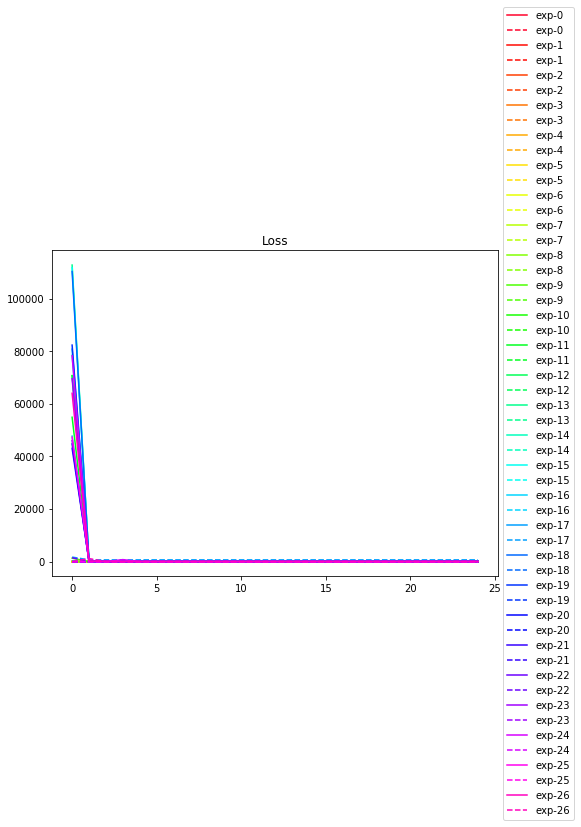

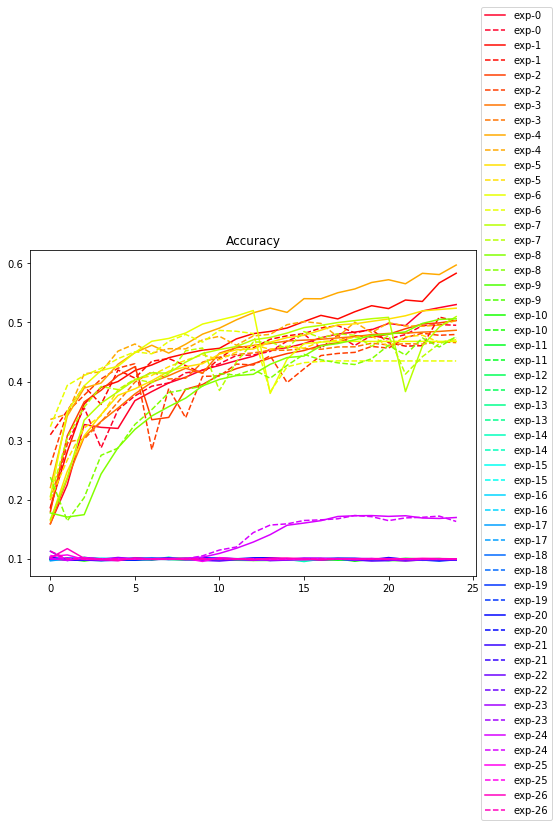

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()